In [1]:
!pip install scikeras


# Importando as bibliotecas necessárias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.regularizers import l2


# Carregamento dos Dados Pré-processados

In [6]:
processed_data_path = '../data/processed/normalized_stock_data.csv'
stock_data = pd.read_csv(processed_data_path, index_col=0).sort_values('Date')

stock_data

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
1962-01-02,0.000167,0.000975,0.001048,0.001120,0.000962,0.005879
1962-01-03,0.000153,0.000894,0.000897,0.000985,0.000908,0.012068
1962-01-04,0.000158,0.000921,0.000923,0.001048,0.000891,0.006189
1962-01-05,0.000143,0.000840,0.000941,0.000976,0.000908,0.010831
1962-01-08,0.000137,0.000805,0.000790,0.000881,0.000801,0.015782
...,...,...,...,...,...,...
2024-10-25,0.922834,0.916367,0.920504,0.924238,0.914783,0.089138
2024-10-28,0.919384,0.912933,0.916413,0.921601,0.913278,0.086102
2024-10-29,0.904069,0.897690,0.901959,0.906616,0.904114,0.132555


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
stock_data['Close'] = scaler.fit_transform(stock_data[['Close']])

# Criando sequências para treinamento
def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step])
        y.append(data[i+time_step])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_sequences(stock_data['Close'].values, time_step)


# Divisão dos Dados em Treino e Teste

In [9]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Exibindo as dimensões dos dados
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (12605, 60), y_train shape: (12605,)
X_test shape: (3152, 60), y_test shape: (3152,)


# Construção do Modelo LSTM

In [33]:
def create_model():
    model = Sequential()
    model.add(LSTM(32, kernel_regularizer=l2(0.01), return_sequences=True, input_shape=(time_step, 1)))
    model.add(Dropout(0.1))
    model.add(LSTM(16, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = create_model()
model.summary()

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 60, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 25)             │           425 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,939 (31.01 KB)

 Trainable params: 7,939 (31.01 KB)

 Non-trainable params: 0 (0.00 B)

# Treinamento do Modelo

In [34]:
# Configurando o EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Treinando o modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 47s 80ms/step - loss: 0.0188 - val_loss: 0.0122
Epoch 2/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 33s 85ms/step - loss: 6.7291e-04 - val_loss: 0.0082
Epoch 3/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - loss: 5.0492e-04 - val_loss: 0.0070
Epoch 4/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 29s 72ms/step - loss: 3.7460e-04 - val_loss: 0.0042
Epoch 5/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - loss: 3.4327e-04 - val_loss: 0.0073
Epoch 6/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 29s 73ms/step - loss: 3.1442e-04 - val_loss: 0.0028
Epoch 7/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 49s 94ms/step - loss: 3.2782e-04 - val_loss: 0.0022
Epoch 8/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 39s 88ms/step - loss: 2.7947e-04 - val_loss: 0.0083
Epoch 9/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 29s 73ms/step - loss: 2.5364e-04 - val_loss: 0.0099
Epoch 10/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step - loss: 2.3128e-04 - val_loss: 0.0098


# Avaliação do Modelo

In [35]:
predictions = model.predict(X_test)

# Revertendo a normalização
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculando métricas de desempenho
mae = mean_absolute_error(y_test_scaled, predictions)
rmse = np.sqrt(mean_squared_error(y_test_scaled, predictions))
mape = np.mean(np.abs((y_test_scaled - predictions) / y_test_scaled)) * 100
r2 = r2_score(y_test_scaled, predictions)

# Exibindo os resultados
print(f"MAE (Mean Absolute Error): {mae}")
print(f"RMSE (Root Mean Squared Error): {rmse}")
print(f"MAPE (Mean Absolute Percentage Error): {mape}%")
print(f"R² Score: {r2}")

99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step
MAE (Mean Absolute Error): 0.040309386941242864
RMSE (Root Mean Squared Error): 0.04612313085218002
MAPE (Mean Absolute Percentage Error): 5.8120848836443075%
R² Score: 0.8507864475605205


# Historico de Treinamento


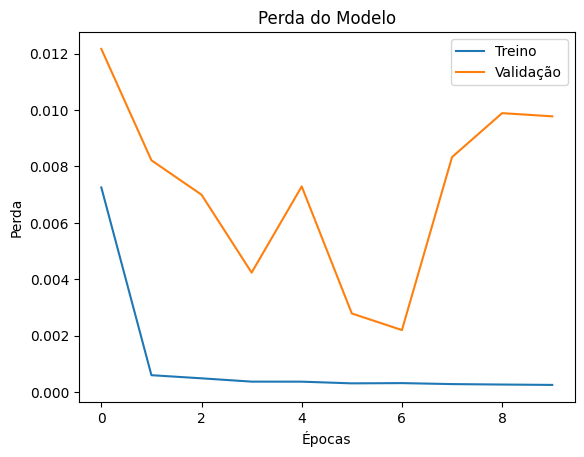

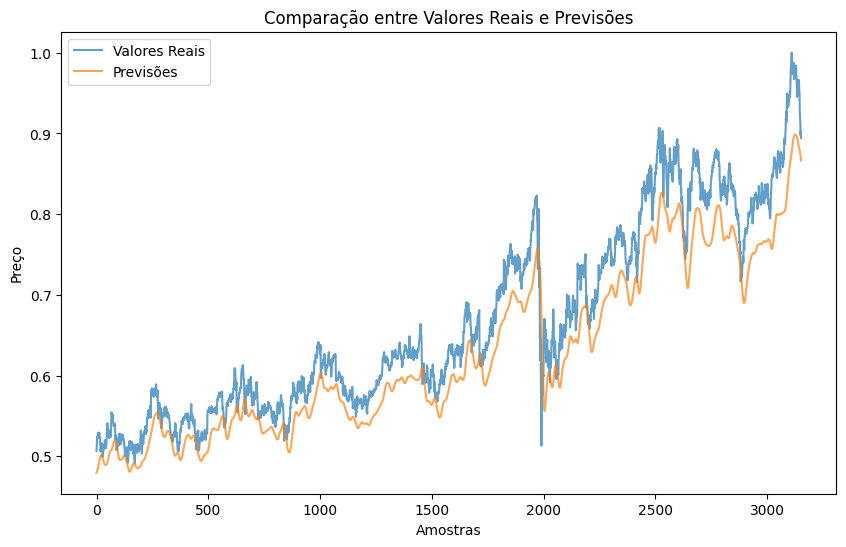

In [37]:
# Plotando a perda durante o treinamento
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda do Modelo')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

# Comparando previsões com valores reais
plt.figure(figsize=(10, 6))
plt.plot(y_test_scaled, label='Valores Reais', alpha=0.7)
plt.plot(predictions, label='Previsões', alpha=0.7)
plt.title('Comparação entre Valores Reais e Previsões')
plt.xlabel('Amostras')
plt.ylabel('Preço')
plt.legend()
plt.show()

# Salvando o modelo

In [38]:
model_save_path = '../saved_models/lstm_stock_prediction_model.h5'
model.save(model_save_path)